# Fitting non-polynomial functions

(Note: This notebook uses the package `sdeint`, which can be installed using `pip install sdeint`.)

By default, `pyddsde` fits polynomial functions for drift and diffusions. However, if the expected functional form is not a polynomial, `pyddsde` provides the option to fit using a custom library of candidate functions.

In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import pyddsde
import sdeint
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let us generate some simulated time-series data with specified drift and diffusion, and try to recover the drift and diffusion back from the time-series. The functions we use are just for demonstration, and may not have any ecological or physical significance.

In [11]:
def f(x, t): return np.cos(x) + 0.5 * np.sin(2 * x)
def g(x, t): return 1

# Simulate and plot data
t_inc = 0.01
timepoints = 1e5
tspan = np.arange(0, t_inc * timepoints, step=t_inc)
data = sdeint.itoint(f=f, G=g, y0=0.1, tspan=tspan)

Number of bins chosen: 91
| M range              : (-13.561, 13.276)|
| M mean               :      0.191     |
| |M| range            :  (0.0, 13.561) |
| |M| mean             :      4.599     |
| Autocorr time (M)    :     5653234    |
| (Dt, dt)             :     (1, 1)     |



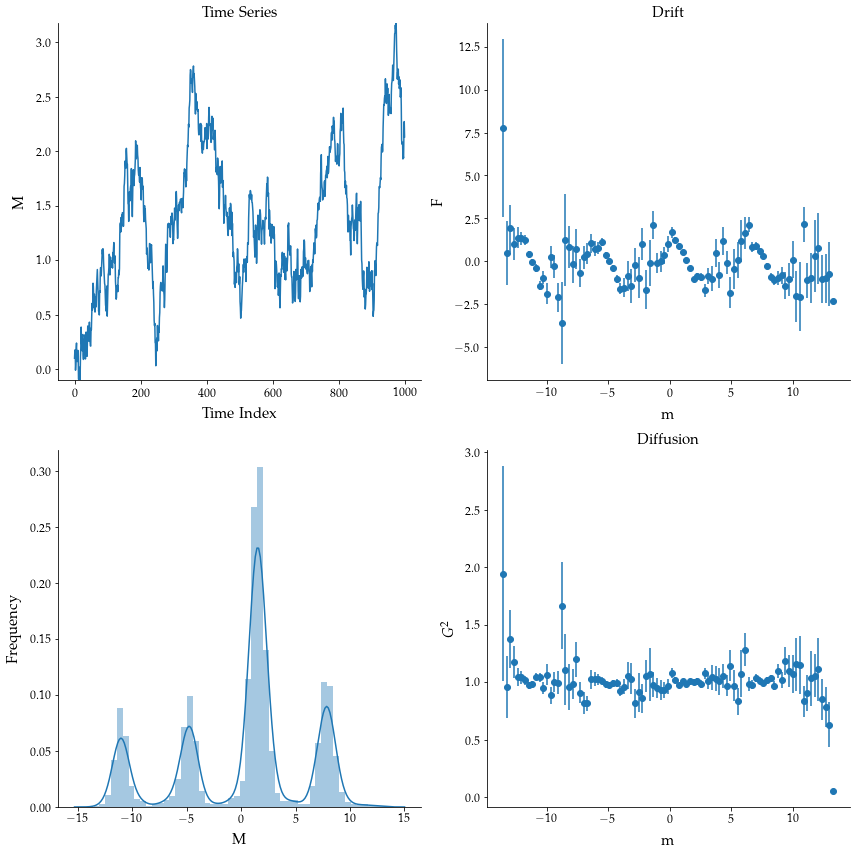

In [12]:
ddsde = pyddsde.Characterize([data], tspan)

The custom library can be defined as a list of functions, as follows. In this case, our library consists of sinusoids of 3 different frequencies, and the constant function. The functions you choose to include in the library will depend on the specific problem.

In [6]:
library = [
        lambda x: np.ones_like(x),  # Each function in the library, when called with an np.array, should return an array of the same shape.
        lambda x: np.sin(x),
        lambda x: np.cos(x),
        lambda x: np.sin(2 * x),
        lambda x: np.cos(2 * x),
        lambda x: np.sin(3 * x),
        lambda x: np.cos(3 * x),
    ]

While calling `ddsde.fit`, the library can now be passed as a parameter. The output will now just be a list of coefficients, corresponding to each function in the library. Two arrays are returned, corresponding to the coefficient values and their standard errors respectively.

In [14]:
F = ddsde.fit('F', library=library, tune=False, threshold=0.2)
F

(array([0.        , 0.        , 1.00487573, 0.39949294, 0.        ,
        0.        , 0.        ]),
 array([0.07385775, 0.10895714, 0.09959863, 0.10459299, 0.10022658,
        0.072476  , 0.0729914 ]))

Here, the second and third coefficients, corresponding to the $\cos x$ and $\sin 2x$ terms of the library, are non-zero: this matches with our original model.

In [18]:
G = ddsde.fit('G', library=library, tune=False, threshold=0.2)
G

(array([1.00119486, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ]),
 array([0.01044612, 0.01541042, 0.0140868 , 0.01479318, 0.01417561,
        0.01025069, 0.01032359]))

*Note:* Although in this case we used the same library for both drift and diffusion, this need not be the case in general: if required, we can use different libraries while fitting different functions.